In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForTokenClassification,
)

import gc
import copy
import random

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import src.utils

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

In [3]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

USE_CRF = True
EXPERT = 'ALL'

SEED = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 False
Path:		 /home/ec2-user/developer/prottrans-t5-signalpeptide-prediction
Using device:	 cuda:0


In [4]:
t5_tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    do_lower_case=False,
    use_fast=True,
    legacy=False
)

In [5]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
annotations_name = 'Label' # Choose Type or Label

df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

dataset_signalp_type_splits = {}

dataset_signalp_type_splits.update(
    {'ALL': src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        encoder=src.config.label_encoding,
    )})

for sequence_type in src.config.type_encoding.keys():
    dataset_signalp = src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        encoder=src.config.select_encoding_type[sequence_type],
        sequence_type=sequence_type
        )
    dataset_signalp_type_splits.update({sequence_type: dataset_signalp})

del df_data

In [6]:
dataset_signalp = dataset_signalp_type_splits[EXPERT]
display(dataset_signalp)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12462
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4149
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4147
    })
})

In [7]:
for x in range(3):
    print(len(dataset_signalp['valid'][x]['labels']))
    print(*dataset_signalp['valid'][x]['labels'])

70
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
70
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
70
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [8]:
t5_base_model = T5EncoderModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    device_map='auto',
    load_in_8bit=False,
    custom_num_labels=len(src.config.select_decoding_type[EXPERT]),
    custom_dropout_rate=0.1,
    use_crf=USE_CRF,
)

tmp_lin = nn.Linear(
    in_features=t5_base_model.config.hidden_size,
    out_features=t5_base_model.custom_num_labels
)
t5_base_model.custom_classifier.weight = tmp_lin.weight
t5_base_model.custom_classifier.bias = tmp_lin.bias

if USE_CRF:
    t5_base_model.crf.reset_parameters()
    
if USE_CRF:
    modules_to_save = ['custom_classifier', 'crf']
else:
    modules_to_save = ['custom_classifier']

lora_config = LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=['q', 'k', 'v', 'o'],
    bias="none",
    modules_to_save=modules_to_save,
)

t5_lora_model = peft.get_peft_model(t5_base_model, lora_config)
t5_lora_model.print_trainable_parameters()

Some weights of T5EncoderModelForTokenClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['custom_classifier.bias', 'crf.transitions', 'crf.end_transitions', 'custom_classifier.weight', 'crf.start_transitions']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,944,556 || all params: 1,212,086,380 || trainable%: 0.3254352218692532


In [9]:
# print([x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()])
# print(t5_lora_model.custom_classifier.modules_to_save.default.weight.mean())
# print(t5_lora_model.custom_classifier.modules_to_save.default.bias.mean())

In [10]:
data_collator = DataCollatorForTokenClassification(tokenizer=t5_tokenizer)

training_args = TrainingArguments(
    output_dir='./checkpoints',
    learning_rate=src.config.lr,
    per_device_train_batch_size=src.config.batch_size,
    per_device_eval_batch_size=src.config.batch_size,
    num_train_epochs=src.config.num_epochs,
    logging_steps=src.config.logging_steps,
    # save_strategy="steps",
    # save_steps=src.config.save_steps,
    # evaluation_strategy="steps",
    # eval_steps=src.config.eval_steps,
    # gradient_accumulation_steps=accum,
    # load_best_model_at_end=True,
    # save_total_limit=5,
    seed=42,
    # fp16=True,
    # deepspeed=deepspeed_config,
    remove_unused_columns=False,
    label_names=['labels'],
    # debug="underflow_overflow",
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=dataset_signalp['train'],
    eval_dataset=dataset_signalp['valid'],
    data_collator=data_collator,
    compute_metrics=src.model_new.compute_metrics,
)

In [11]:
gc.collect()
torch.cuda.empty_cache()
# torch.mps.empty_cache()

trainer.train()

/home/ec2-user/developer/prottrans-t5-signalpeptide-prediction/.venv/lib/python3.11/site-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:493.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Step,Training Loss
1,1.965100
2,1.959000
3,1.960900
4,1.954800
5,1.952800
6,1.955000
7,1.938900
8,1.939500
9,1.936600
10,1.947000


TrainOutput(global_step=779, training_loss=0.36302826027786395, metrics={'train_runtime': 1205.4589, 'train_samples_per_second': 10.338, 'train_steps_per_second': 0.646, 'total_flos': 6434037446350608.0, 'train_loss': 0.36302826027786395, 'epoch': 1.0})

In [12]:
# [x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()]

In [13]:
metrics=trainer.evaluate()
print(metrics)

{'eval_loss': 0.12262660264968872, 'eval_accuracy_metric': 0.9686464896877044, 'eval_precision_metric': 0.9686464896877044, 'eval_recall_metric': 0.9686464896877044, 'eval_f1_metric': 0.9686464896877044, 'eval_matthews_correlation': 0.2802063757462539, 'eval_confusion_matrix': array([[201431,     17,    356,   1337,    239,      0],
       [    10,   5960,     30,      4,    250,      0],
       [  2142,     34,   4189,    718,    226,      0],
       [  2088,     58,    192,  51431,    420,     73],
       [   212,    133,     46,    292,  15329,     40],
       [    12,      0,     19,     91,     67,   2984]]), 'eval_runtime': 261.2618, 'eval_samples_per_second': 15.881, 'eval_steps_per_second': 0.995, 'epoch': 1.0}


In [14]:
training_log = pd.DataFrame(trainer.state.log_history)
display(training_log)

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_accuracy_metric,eval_precision_metric,eval_recall_metric,eval_f1_metric,eval_matthews_correlation,eval_confusion_matrix,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.9651,9.987163e-05,0.00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.9590,9.974326e-05,0.00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.9609,9.961489e-05,0.00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.9548,9.948652e-05,0.01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.9528,9.935815e-05,0.01,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,0.0898,2.567394e-07,1.00,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,0.0184,1.283697e-07,1.00,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
778,0.0069,0.000000e+00,1.00,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779,NaN,NaN,1.00,779,1205.4589,10.338,0.646,6.434037e+15,0.363028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
adapter_location = f'/models/moe_v1_expert_{EXPERT}_1'
training_log['eval_confusion_matrix'] = training_log['eval_confusion_matrix'].apply(lambda x: x.tolist() if type(x)==np.ndarray else None)
t5_lora_model.save_pretrained(ROOT + adapter_location)
training_log.to_csv(ROOT + adapter_location + '/training_log.csv', index=False)
training_log.to_parquet(ROOT + adapter_location + '/training_log.parquet')

In [16]:
# display(pd.Series([item for row in dataset_signalp['train']['labels'] for item in row]).value_counts())
# display(pd.Series([item for row in dataset_signalp['valid']['labels'] for item in row]).value_counts())
# display(pd.Series([item for row in dataset_signalp['test']['labels'] for item in row]).value_counts())

0    609523
3    163298
4     47167
2     22067
1     19129
5     10155
Name: count, dtype: int64

0    202812
3     54262
4     16052
2      7309
1      6254
5      3173
Name: count, dtype: int64

0    202874
3     54313
4     15677
2      7629
1      6259
5      3134
Name: count, dtype: int64

{0: 'I', 1: 'L', 2: 'M', 3: 'O', 4: 'S', 5: 'T'}


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Label', ylabel='True Label'>

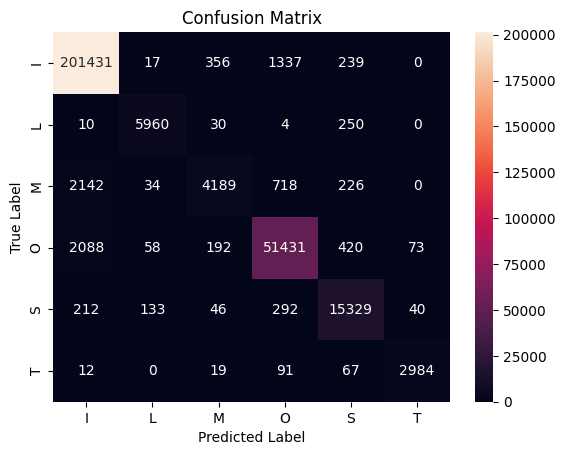

In [17]:
src.model_new.make_confusion_matrix(
    training_log['eval_confusion_matrix'].iloc[-1],
    src.config.select_decoding_type[EXPERT])

In [18]:
training_log = pd.DataFrame(trainer.state.log_history)
if 'eval_confusion_matrix' in training_log.columns:
    training_log['eval_confusion_matrix'] = training_log['eval_confusion_matrix'].apply(lambda x: x.tolist() if type(x)==np.ndarray else None)
adapter_location = '/models/expert_testing_1/' + EXPERT + '_expert/'
t5_lora_model.save_pretrained(ROOT + adapter_location)
training_log.to_csv(ROOT + adapter_location + '/training_log.csv', index=False)
training_log.to_parquet(ROOT + adapter_location + '/training_log.parquet')

In [28]:
# _ds_index = 3250
_ds_index = 3250
_ds_type = 'test'
USE_CRF = False

_input_ids_test = t5_tokenizer.decode(dataset_signalp[_ds_type][_ds_index]['input_ids'][:-1])
_labels_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['labels'] + [-100]]).to(device)
_attention_mask_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['attention_mask']]).to(device)

_labels_test_decoded = [src.config.label_decoding[x] for x in _labels_test.tolist()[0][:-1]]

print('Iput IDs:\t', _input_ids_test)
print('Labels:\t\t', *_labels_test.tolist()[0])
print('Labels Decoded:\t', *_labels_test_decoded)
print('Attention Mask:\t', *_attention_mask_test.tolist()[0])
print('----')

preds = src.model_new.predict_model(
    sequence=_input_ids_test,
    tokenizer=t5_tokenizer,
    model=t5_lora_model,
    labels=_labels_test,
    attention_mask=_attention_mask_test,
    device=device,
    viterbi_decoding=USE_CRF,
    )

_result = src.model_new.translate_logits(
    logits=preds.logits,
    viterbi_decoding=USE_CRF,
    decoding=src.config.label_decoding
    )

print('Result: \t',* _result)

Iput IDs:	 M D F L H R N G V L I I Q H L Q K D Y R A Y Y T F L N F M S N V G D P R N I F F I Y F P L C F Q F N Q T V G T K M I W V A V I G D W L N L I
Labels:		 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 -100
Labels Decoded:	 O O O O O O O O O O O O O O O O O O O O O O O O M M M M M M M M M M M M M M M M M M M M M I I I I I I I I I I I M M M M M M M M M M M M M M
Attention Mask:	 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
----
Result: 	 I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I M M M M M M M M I I I I I I I I I I I I M I I I M M I I I M I I I L
